In [1]:
string = "ANANNA"
name = "H_ACA_Box"

indicies = []

bases = ["A","T","C","G"]

temp = string.replace("N", "A")

dis = {}

k = 0
for i in string:
    if i == "N":
        indicies.append(k)

    k += 1

temp2 = list(temp)

for i in indicies:
    for base in bases:
        temp2 = list(temp2)
        temp2[i] = base
        temp2 = "".join(temp2)

        dis.update({temp2:name})

print(dis)

{'AAAAAA': 'H_ACA_Box', 'ATAAAA': 'H_ACA_Box', 'ACAAAA': 'H_ACA_Box', 'AGAAAA': 'H_ACA_Box', 'AGATAA': 'H_ACA_Box', 'AGACAA': 'H_ACA_Box', 'AGAGAA': 'H_ACA_Box', 'AGAGTA': 'H_ACA_Box', 'AGAGCA': 'H_ACA_Box', 'AGAGGA': 'H_ACA_Box'}


In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Turn the merged dataset to a longer format suitable for joining with the filtered dataset
def merged_to_longer(merged_df):
    longer_df = []

    i = 0
    for index,row in merged_df.iterrows():
        items = row["original_id_set"].replace("'", "").replace(' ', "").replace("[", "").replace("]","").split(sep = ",")

        for entry in items:
            new_row = row.copy()
            new_row['original_id_set'] = entry
            longer_df.append(new_row)

        i += 1

    return pd.DataFrame(longer_df)

def calculate_source_length(start, avg):
    if avg == 0:
        length = 10000

    else:
        length = (start - 1) / avg

    return length + 1


def get_last_two_items(s, sep="-"):
    items = s.split(sep)
    return sep.join(items[-2:]) if len(items) > 1 else s

# def annotate_merged_counts()
datasets = ["cpms/micpm.csv", "cpms/rcpm.csv", "cpms/snocpm.csv", "cpms/sncpm.csv"]
datasets_mergedcounts = ["/Users/kenminsoo/Desktop/sRNAfrag_v4/Code/benchmark_flai/merged_counts.csv","/Volumes/Extreme_SSD/h_sapiens/r_out/tables/merged_counts.csv", "/Volumes/Extreme_SSD/h_sapiens/sno_out/tables/merged_counts.csv", "/Volumes/Extreme_SSD/h_sapiens/sn_out/tables/merged_counts.csv"]
datasets_filteredcounts = ["/Users/kenminsoo/Desktop/sRNAfrag_v4/Code/benchmark_flai/filtered_counts.csv", "/Volumes/Extreme_SSD/h_sapiens/r_out/tables/filtered_counts.csv", "/Volumes/Extreme_SSD/h_sapiens/sno_out/tables/filtered_counts.csv", "/Volumes/Extreme_SSD/h_sapiens/sn_out/tables/filtered_counts.csv"]
motifs = {"ATGATGA":"C_Box", "GTGATGA":"C_Box", "CTGA":"D_box", 'AAAAAA': 'H_ACA_Box', 'ATAAAA': 'H_ACA_Box', 'ACAAAA': 'H_ACA_Box', 'AGAAAA': 'H_ACA_Box', 'AGATAA': 'H_ACA_Box', 'AGACAA': 'H_ACA_Box', 'AGAGAA': 'H_ACA_Box', 'AGAGTA': 'H_ACA_Box', 'AGAGCA': 'H_ACA_Box', 'AGAGGA': 'H_ACA_Box'}

labels = ["mirna", "rrna", "snorna", "snrna"]
filtering_terms = ["mi", "rRNA", "sno", "snRNA"]
imported = []


delim = "-_"

i = 0 
for dataset in datasets:

    # Import and add labels to the dataset if needed
    imported.append(pd.read_csv(dataset))
    filtered_counts_df = pd.read_csv(datasets_filteredcounts[i])

    filtered_counts_df["ID"] = filtered_counts_df["ID"].apply(get_last_two_items)

    annotation_set = defaultdict(set)

    # Filter the dataset based upon outside maps
    if datasets_mergedcounts[i] != "":
        filtering = pd.read_csv(datasets_mergedcounts[i])

        filtering["Filtering"] = (filtering["outside_maps"] == "{''}")
        filtering["Filtering2"] = (filtering["outside_maps"].str.contains(filtering_terms[i]))
        filtering["Filtering3"] = (filtering["outside_maps"] == "set()")

        filtering_List = list(filtering["new_id"][filtering["Filtering"] + filtering["Filtering2"] + filtering["Filtering3"]])

        imported[i] = imported[i].loc[imported[i]["new_id"].isin(filtering_List)]
        
        # Here we will generate an annotation for the transcript

        # Make it longer
        long_mc = merged_to_longer(filtering)

        long_mc = long_mc.merge(filtered_counts_df, left_on = "original_id_set", right_on = "ID")

        for index,row in long_mc.iterrows():
            within5_5p = False
            within5_3p = False
            # Obtain info about the 5p and 3p positions
            for source_unpack in row["sources"].split(sep = ">"):   
                # further unpack
                furthered = source_unpack.split(sep = "__")

                # obtain start and end loci
                start = int(furthered[0].split(sep = ";")[0])
                end = int(furthered[0].split(sep = ";")[1])
                avg = float(furthered[-1])

                source_length = calculate_source_length(start, avg)

                if start <= 5:
                    within5_5p = True
                    annotation_set[row["new_id"]].add("5_5p")
                    
                
                if source_length - end < 5:
                    within5_3p = True
                    annotation_set[row["new_id"]].add("5_3p")

                
                    

            # Detect motifs
            for motif in motifs:
                if motif in row["sequence"]:
                    annotation_set[row["new_id"]].add(motifs[motif])

    for index,row in imported[i].iterrows():
        original_value = row["new_id"]
        additional_info = list(annotation_set[original_value])
        joined_info = "--".join(additional_info)

        imported[i].at[index, "new_id"] = imported[i].at[index, "new_id"] + delim + labels[i] + delim + joined_info

        

    i += 1

concat_dataset = pd.concat(imported)

concat_dataset = concat_dataset.rename(columns = {"new_id":"sample_id"})

transposed_df = pd.DataFrame(np.transpose(concat_dataset))

new_header = transposed_df.iloc[0] #grab the first row for the header
transposed_df = transposed_df[1:] #take the data less the header row
transposed_df.columns = new_header



In [4]:
transposed_df

sample_id,hg38_merged_1-_mirna-_D_box,hg38_merged_10-_mirna-_5_5p,hg38_merged_100-_mirna-_5_3p,hg38_merged_101-_mirna-_,hg38_merged_102-_mirna-_D_box,hg38_merged_103-_mirna-_,hg38_merged_104-_mirna-_,hg38_merged_105-_mirna-_D_box--5_3p,hg38_merged_106-_mirna-_,hg38_merged_107-_mirna-_,...,hg38_merged_6-_snrna-_,hg38_merged_60-_snrna-_,hg38_merged_61-_snrna-_H_ACA_Box,hg38_merged_62-_snrna-_H_ACA_Box,hg38_merged_65-_snrna-_5_3p,hg38_merged_66-_snrna-_,hg38_merged_67-_snrna-_,hg38_merged_68-_snrna-_H_ACA_Box,hg38_merged_7-_snrna-_,hg38_merged_9-_snrna-_5_3p
merged_Cel1.394066005,2.243496,26.548041,1.495664,74.783213,109.931323,14.956643,20.191467,12925.156587,2.243496,671.179335,...,110.866171,0.0,28.284054,0.0,44.893135,0.0,0.0,8.068351,2.758411,46.990677
merged_Cel2.394069938,3.681441,23.315794,1.533934,74.549185,122.714707,19.634353,21.78186,14361.915736,3.681441,679.839477,...,116.416006,0.0,9.313491,6.008704,25.074782,0.327087,0.0,2.253264,3.11488,54.923306
merged_Cel3.394073826,4.809884,4.809884,1.717816,34.356316,66.651252,21.300916,227.782372,471.025086,6.184137,533.55358,...,238.202359,0.0,9.797055,0.0,6.594171,1.892381,0.0,2.370255,15.431762,302.569659
merged_Cel4.394075785,1.889422,8.5024,0.944711,35.899022,52.588918,14.48557,139.502339,415.987787,8.187496,505.735341,...,395.924433,0.0,8.93152,0.0,0.0,5.175588,0.0,2.160852,14.357498,433.3708
merged_Cel5.394080690,4.76518,3.335626,0.476518,32.879744,20.252016,1.429554,22.634606,929.448409,3.335626,1357.361596,...,20.810209,0.0,9.623053,0.0,29.358138,0.0,0.0,0.0,1.210056,24.162321
merged_Cel6.394077759,5.195403,12.246307,1.113301,41.563222,28.574715,2.968802,32.285717,1098.456594,3.711002,1626.53218,...,18.758119,0.0,0.0,3.244035,6.768803,0.353181,0.0,0.0,0.976465,21.897233
merged_Cel7.394062123,2.300019,48.108733,1.916683,66.317217,36.033632,11.308427,91.425759,8852.58181,5.366711,2577.363059,...,132.542326,5.159101,0.0,0.0,4.100823,0.106986,0.0,1.474029,5.389982,35.765669
merged_Cel8.394081690,1.888886,43.44438,0.839505,76.394948,39.666607,14.691336,93.394922,9780.44218,8.814802,2793.662493,...,114.742674,0.0,0.0,0.0,0.0,0.0,103.885499,1.556337,4.302916,38.151874
merged_Cel9.394052316,1.250875,2.501751,0.625438,19.180089,42.738241,2.918709,42.529762,21482.324819,1.459355,859.142888,...,173.034493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.717062,16.387796


In [5]:
# import sample sheet
samples = pd.read_csv("cpms/sample.csv")
samples = samples.rename(columns = {"sample":"sample_id"})

# obtain info about genes
array = []

for col in transposed_df.columns:
    if col == "sample_id":
        continue

    splitted = col.split(sep = "-_")
    row = [col] + splitted[1:]

    array.append(row)

colnames = ["ID"]
for i in range(len(splitted) - 1):
    colnames.append("Feature_" + str(i))

gene_info = pd.DataFrame(np.array(array), columns = colnames)

In [37]:
import PyWGCNA

transposed_df.to_csv("wgcna.csv",index=True)

wgcna_object = PyWGCNA.WGCNA(name='sRNAfrag',species='homo sapiens',outputPath='',save=True,geneExpPath="wgcna.csv")

Saving data to be True, checking requirements ...


In [38]:
samples.index = samples["sample_id"]

In [39]:
samples.to_csv("samples2.csv")

In [40]:
gene_info.index = gene_info["ID"]
gene_info = gene_info.drop(columns = ["ID"])

KeyError: 'ID'

In [41]:
wgcna_object.updateGeneInfo(geneInfo=gene_info)
wgcna_object.updateSampleInfo(path="cpms/sample.csv")

In [42]:
wgcna_object.geneExpr.to_df().head(5)

,hg38_merged_1-_mirna-_D_box,hg38_merged_10-_mirna-_5_5p,hg38_merged_100-_mirna-_5_3p,hg38_merged_101-_mirna-_,hg38_merged_102-_mirna-_D_box,hg38_merged_103-_mirna-_,hg38_merged_104-_mirna-_,hg38_merged_105-_mirna-_D_box--5_3p,hg38_merged_106-_mirna-_,hg38_merged_107-_mirna-_,...,hg38_merged_6-_snrna-_,hg38_merged_60-_snrna-_,hg38_merged_61-_snrna-_H_ACA_Box,hg38_merged_62-_snrna-_H_ACA_Box,hg38_merged_65-_snrna-_5_3p,hg38_merged_66-_snrna-_,hg38_merged_67-_snrna-_,hg38_merged_68-_snrna-_H_ACA_Box,hg38_merged_7-_snrna-_,hg38_merged_9-_snrna-_5_3p
merged_Cel1.394066005,2.243496,26.548041,1.495664,74.783213,109.931323,14.956643,20.191467,12925.156587,2.243496,671.179335,...,110.866171,0.0,28.284054,0.000000,44.893135,0.000000,0.0,8.068351,2.758411,46.990677
merged_Cel2.394069938,3.681441,23.315794,1.533934,74.549185,122.714707,19.634353,21.781860,14361.915736,3.681441,679.839477,...,116.416006,0.0,9.313491,6.008704,25.074782,0.327087,0.0,2.253264,3.114880,54.923306
merged_Cel3.394073826,4.809884,4.809884,1.717816,34.356316,66.651252,21.300916,227.782372,471.025086,6.184137,533.553580,...,238.202359,0.0,9.797055,0.000000,6.594171,1.892381,0.0,2.370255,15.431762,302.569659
merged_Cel4.394075785,1.889422,8.502400,0.944711,35.899022,52.588918,14.485570,139.502339,415.987787,8.187496,505.735341,...,395.924433,0.0,8.931520,0.000000,0.000000,5.175588,0.0,2.160852,14.357498,433.370800
merged_Cel5.394080690,4.765180,3.335626,0.476518,32.879744,20.252016,1.429554,22.634606,929.448409,3.335626,1357.361596,...,20.810209,0.0,9.623053,0.000000,29.358138,0.000000,0.0,0.000000,1.210056,24.162321


Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



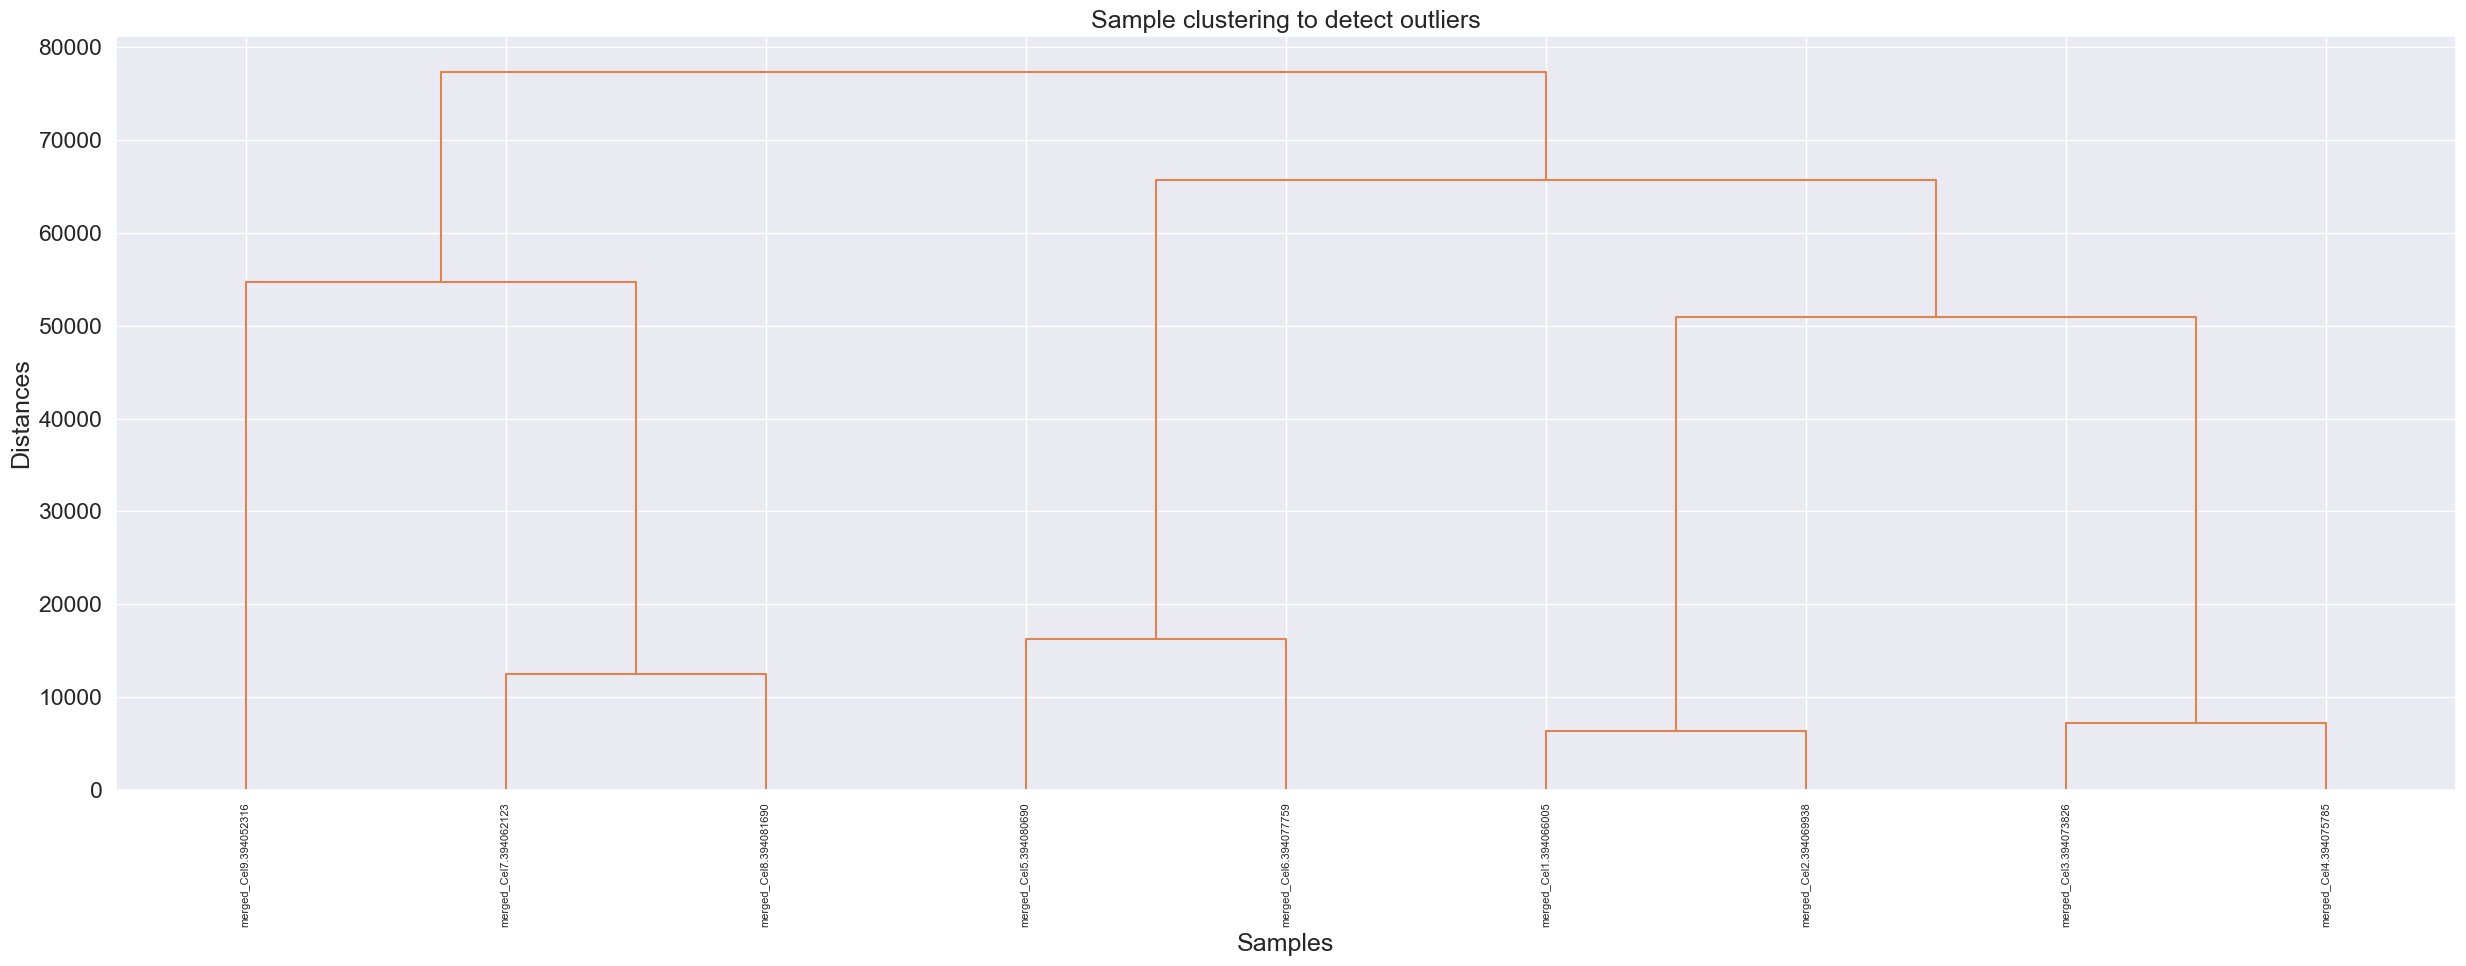

In [43]:
wgcna_object.preprocess()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1475
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.276035  0.878576       0.539253  299.594196   288.05154   
1       2  0.022487  0.195852       0.483539  182.331303   175.04808   
2       3  0.034194 -0.195472       0.454513   127.99771  119.444179   
3       4  0.270557 -0.513753       0.461141   97.126266   87.124185   
4       5  0.499351 -0.716765       0.565644   77.420325   65.566903   
5       6  0.584233 -0.866475       0.544837   63.854602   51.150162   
6       7  0.665047 -0.930957        0.61134   54.006275   41.058462   
7       8  0.712447 -1.013794       0.641847   46.568693   34.197205   
8       9  0.697793 -1.058292       0.613149   40.777427   28.503718   
9      10  0.772637 -1.095926       0.710175   36.156699   23.958031   
10     11   0.80405 -1.107731       0.748807   32.395596   20.290232   
11     13   0.83002 -1.116985    

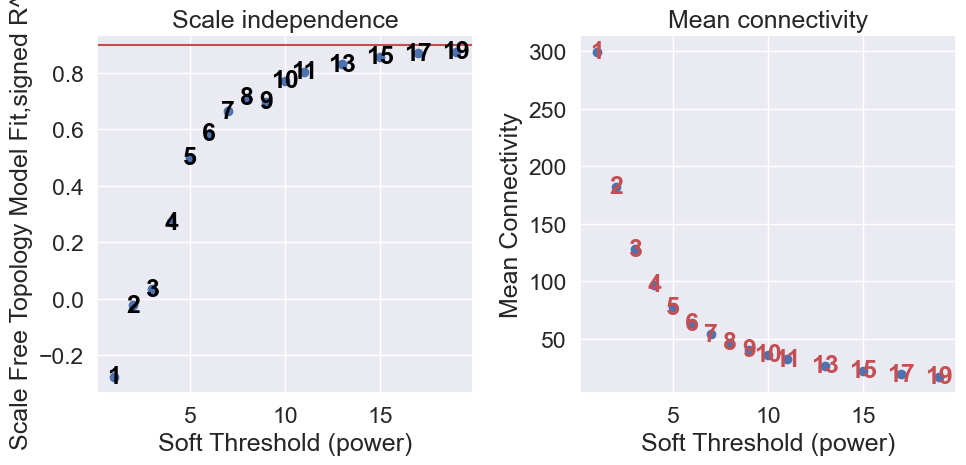

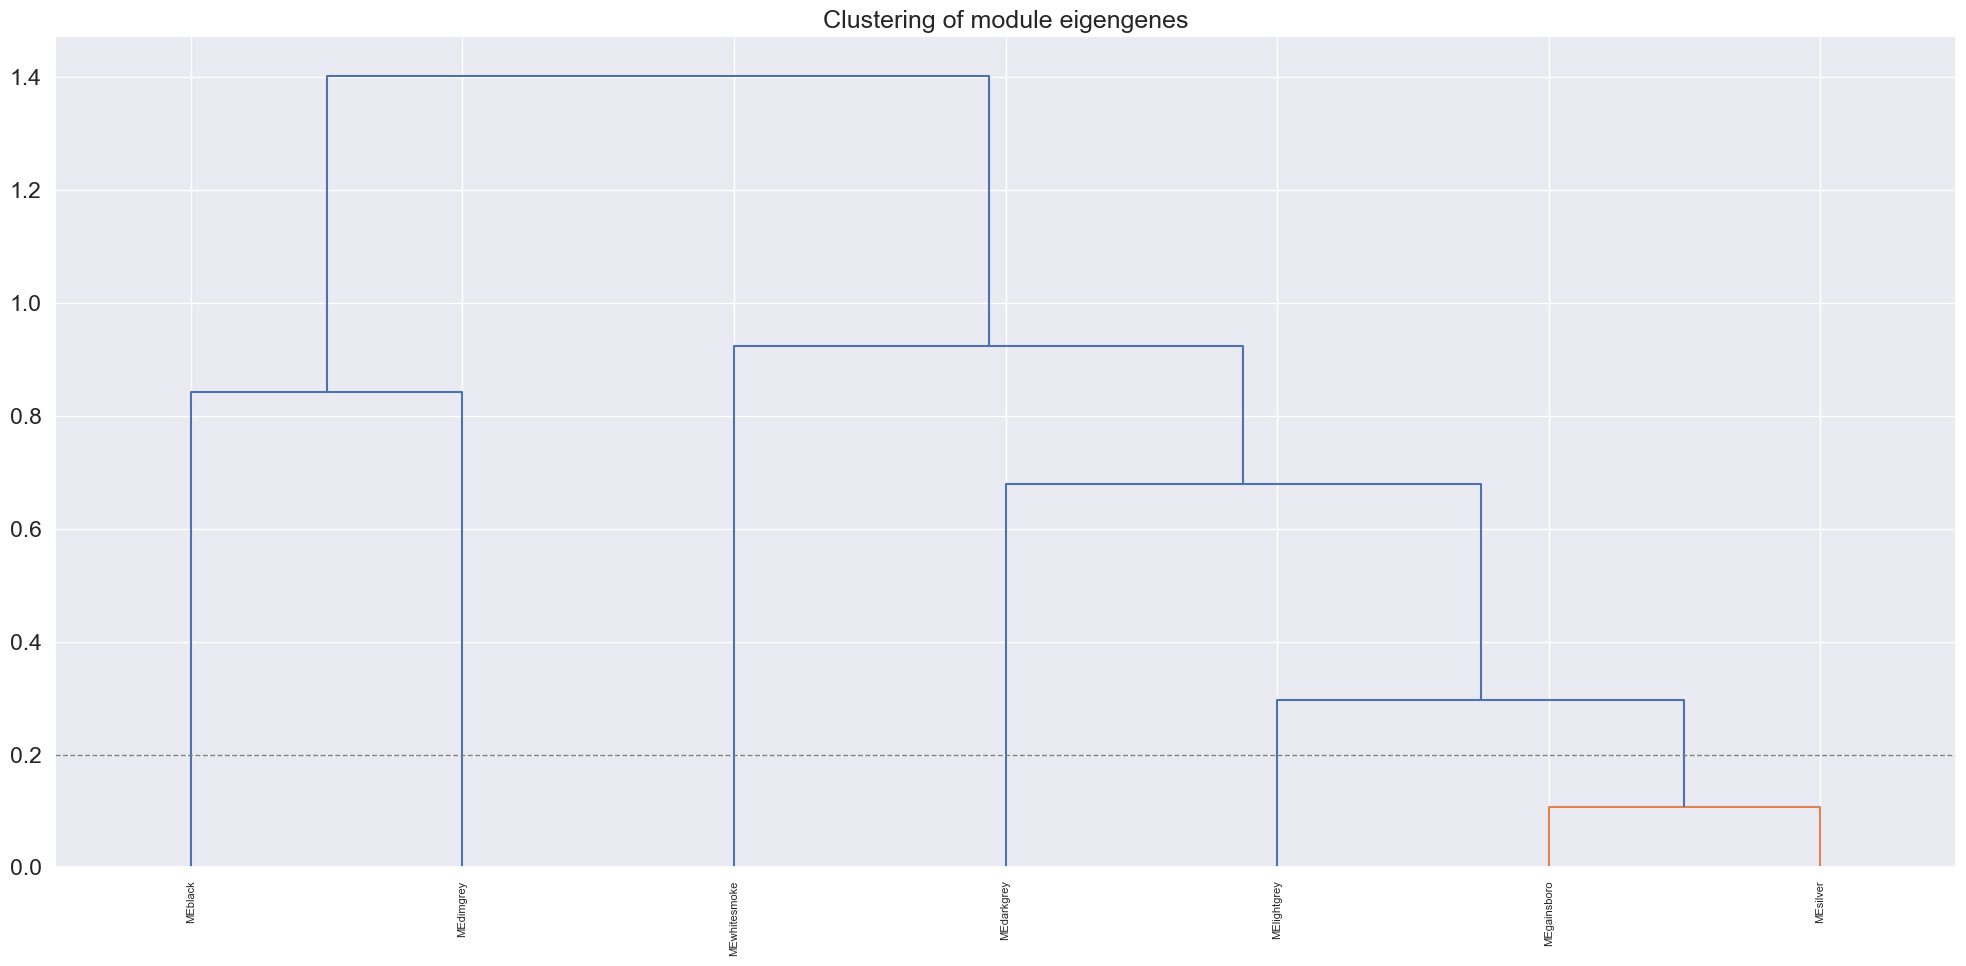

In [44]:
wgcna_object.findModules()

In [45]:
wgcna_object.setMetadataColor('type', {"neuroblastoma":"red",
                                       "breast cancer":"blue",
                                       "epithelial":"green"})

In [46]:
wgcna_object.geneExpr.obs

,type
merged_Cel1.394066005,neuroblastoma
merged_Cel2.394069938,neuroblastoma
merged_Cel3.394073826,neuroblastoma
merged_Cel4.394075785,neuroblastoma
merged_Cel5.394080690,breast cancer
merged_Cel6.394077759,breast cancer
merged_Cel7.394062123,breast cancer
merged_Cel8.394081690,breast cancer
merged_Cel9.394052316,epithelial


In [47]:
wgcna_object.metadataColors

{'type': {'neuroblastoma': 'red',
  'breast cancer': 'blue',
  'epithelial': 'green'}}

Analysing WGCNA...
Calculating module trait relationship ...
	Done..

Adding (signed) eigengene-based connectivity (module membership) ...
	Done..

plotting module heatmap eigengene...
	Done..

plotting module barplot eigengene...
	Done..

doing Enrichr GO analysis for each module...
	gene name didn't found in gene information!
	 Go term analysis can not be done
	Done..



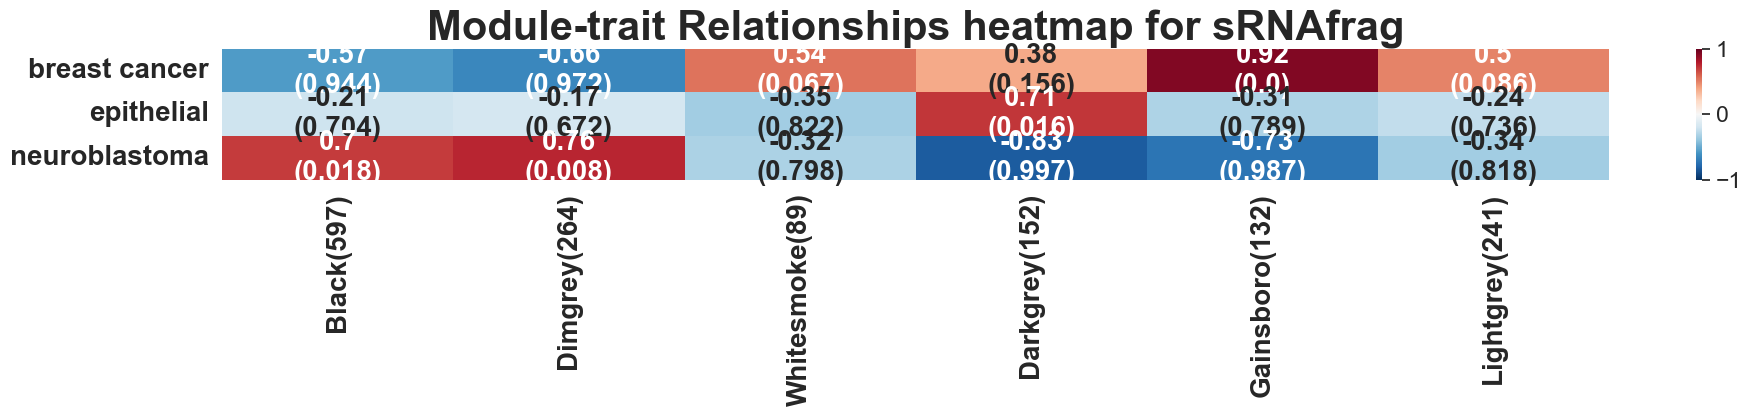

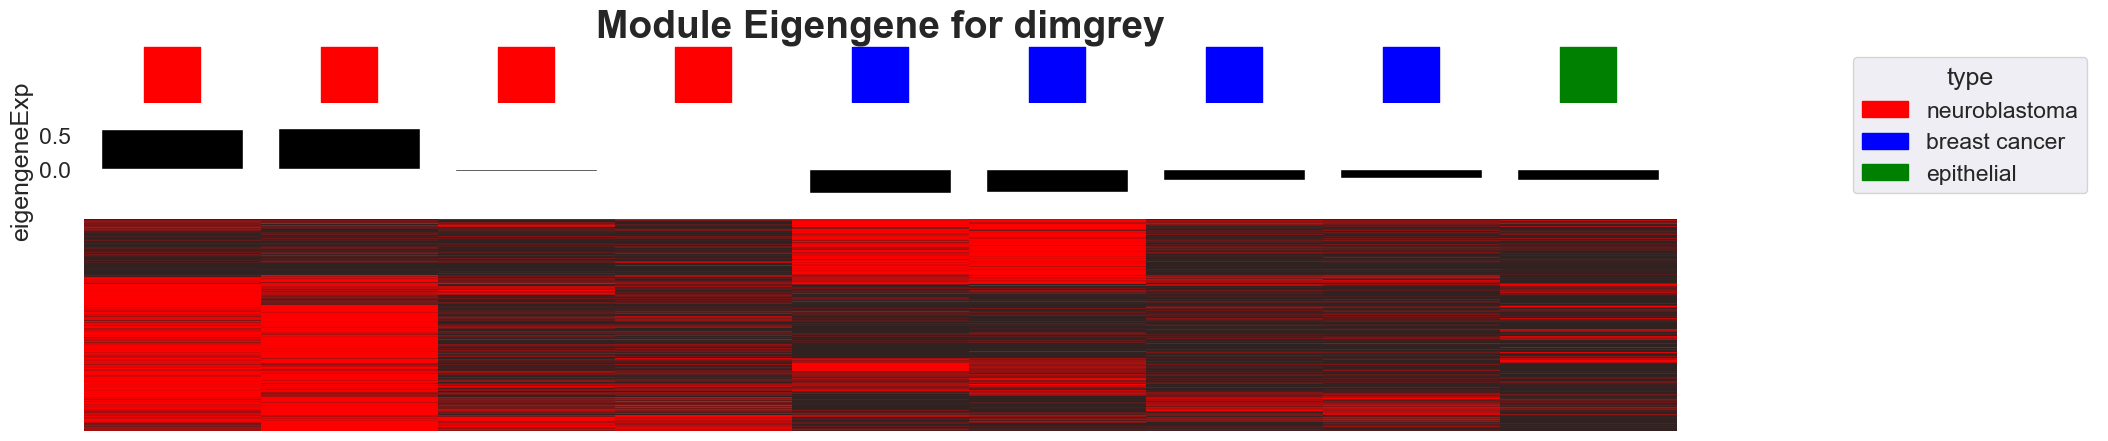

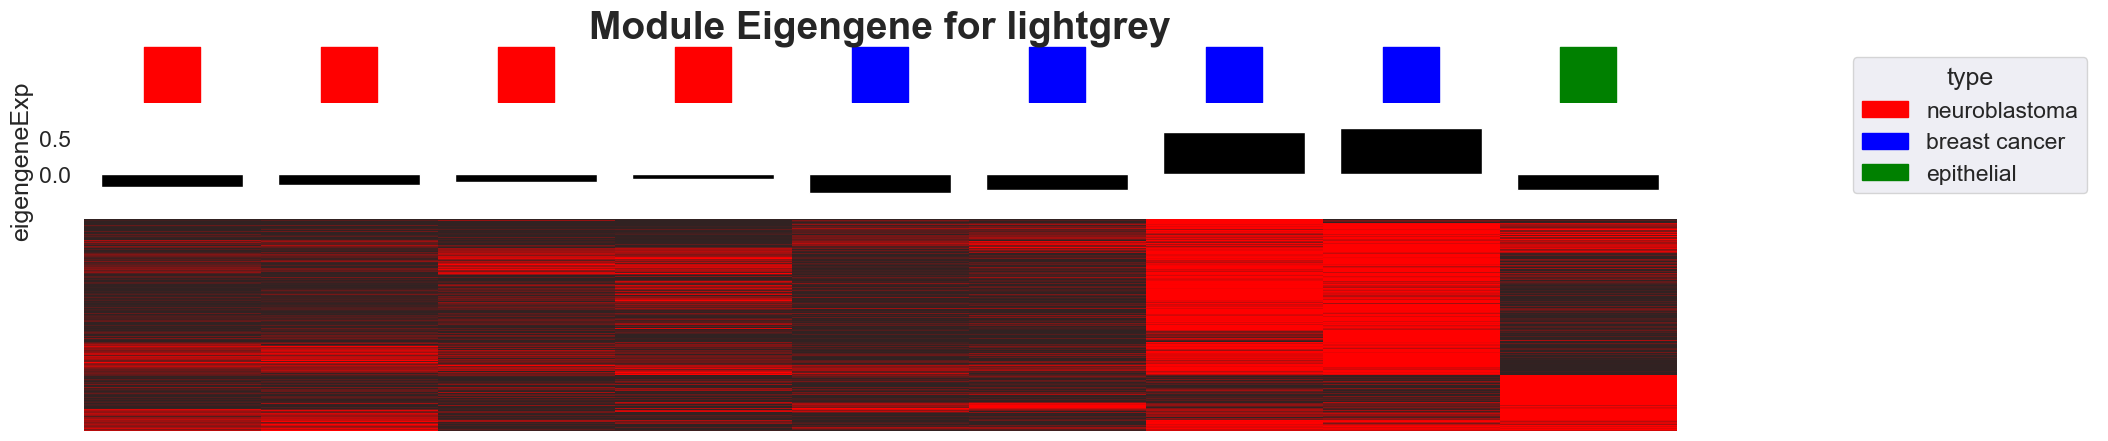

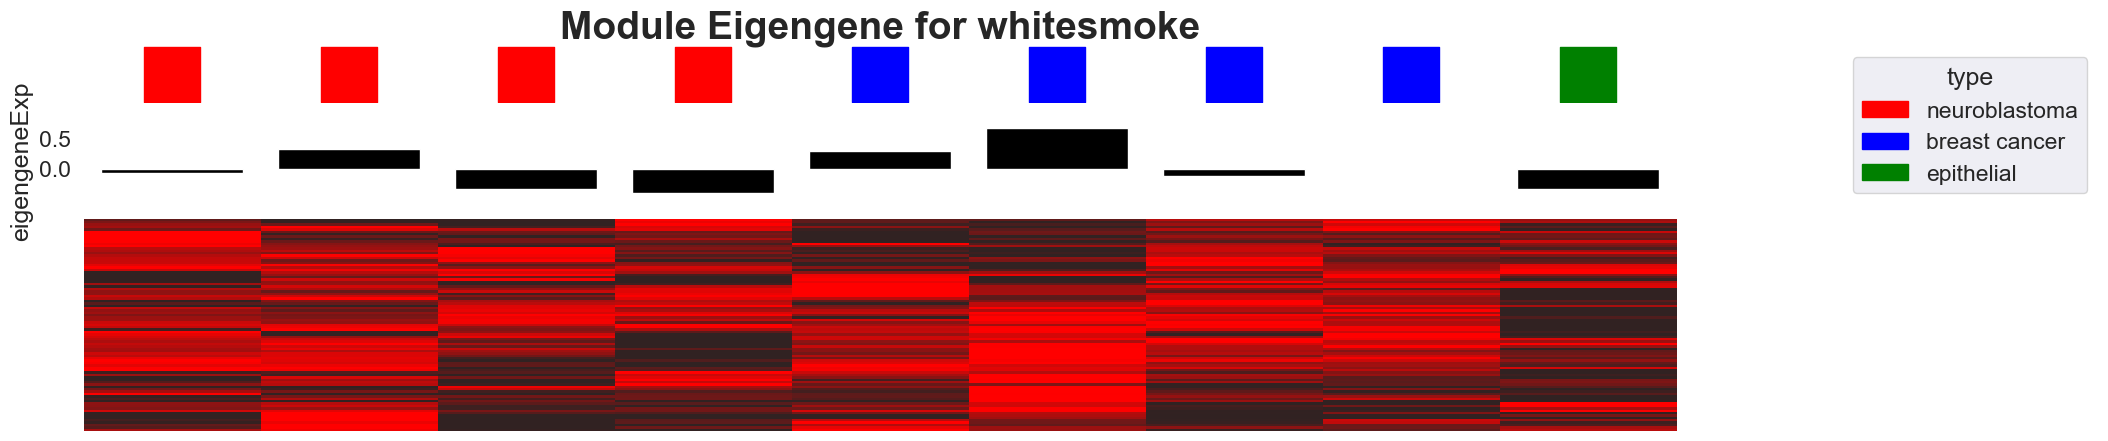

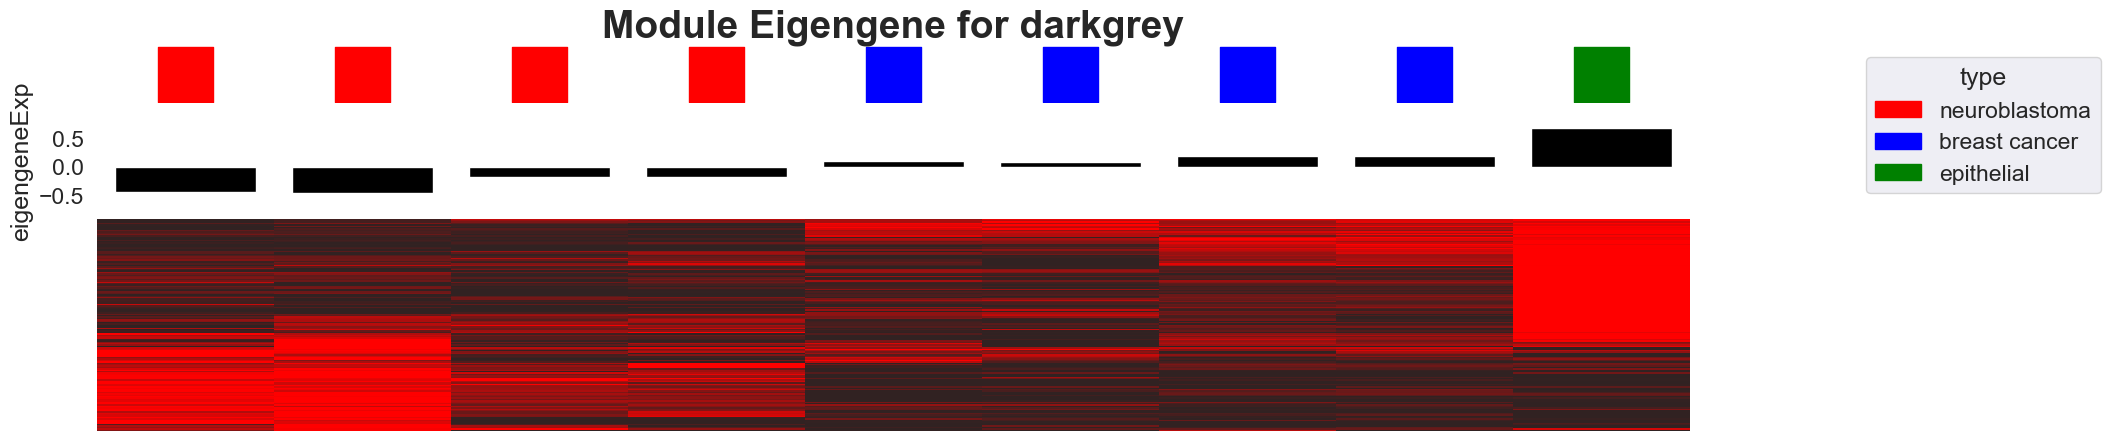

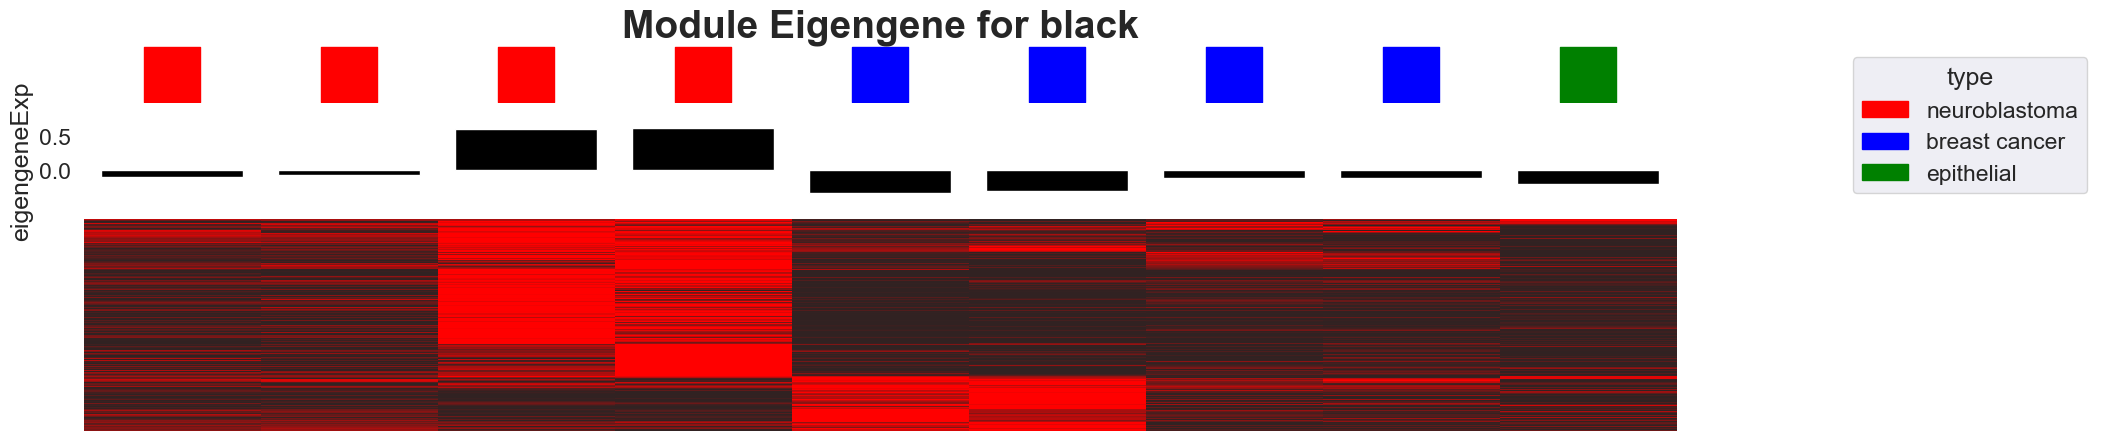

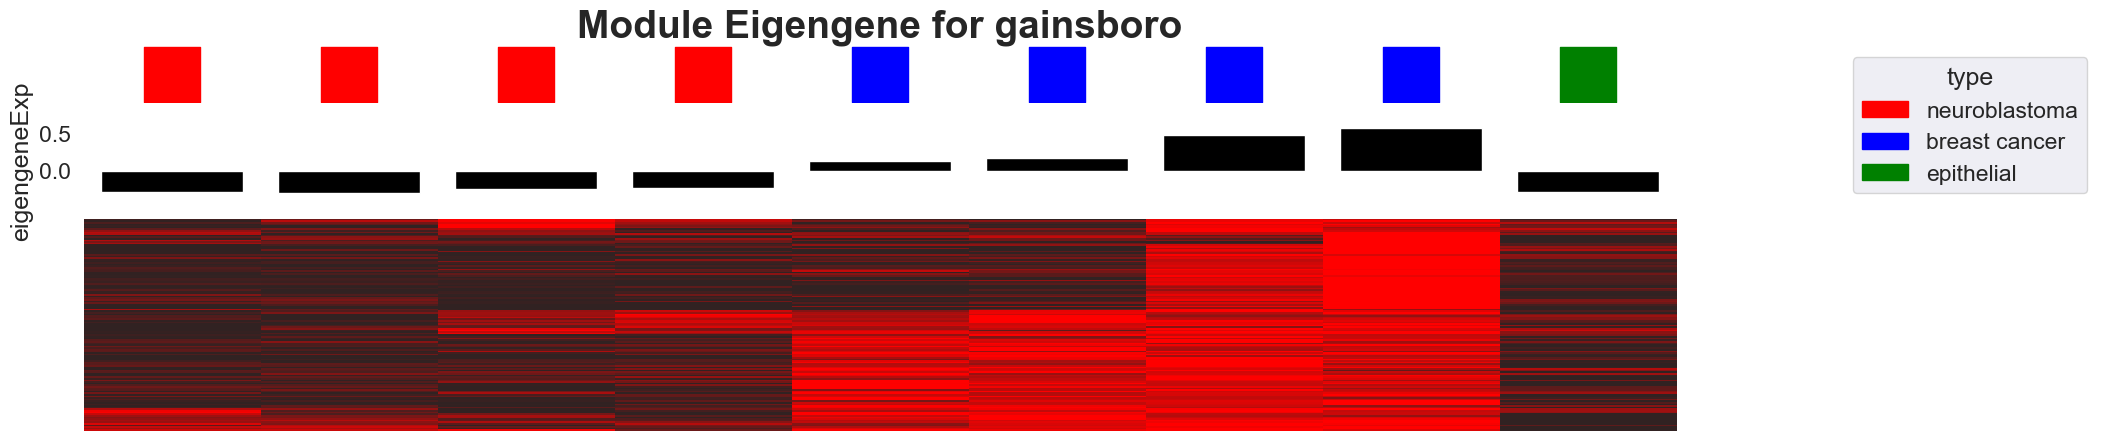

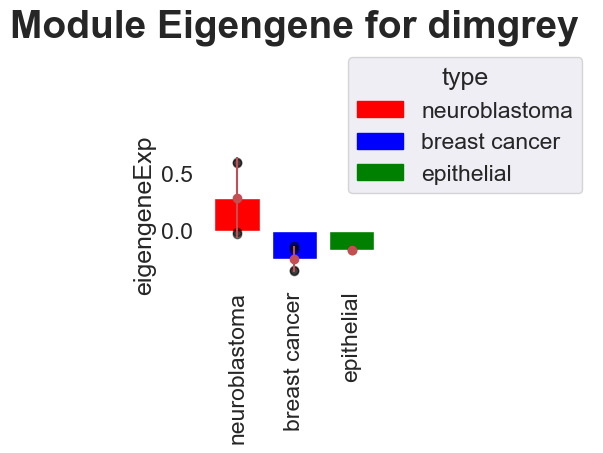

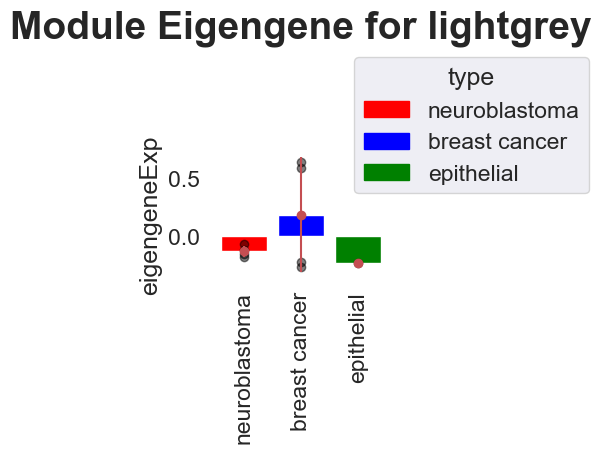

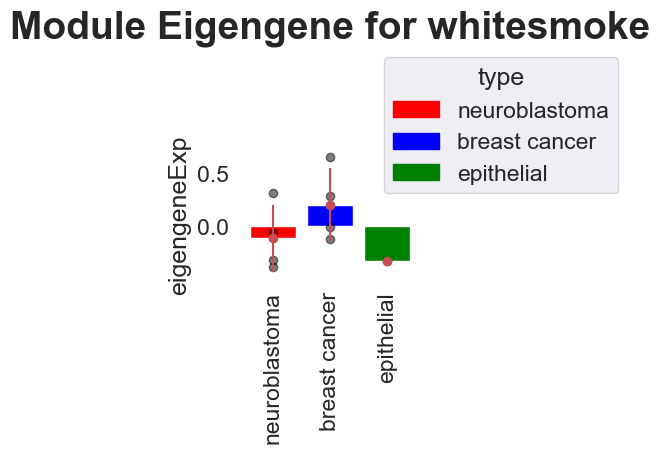

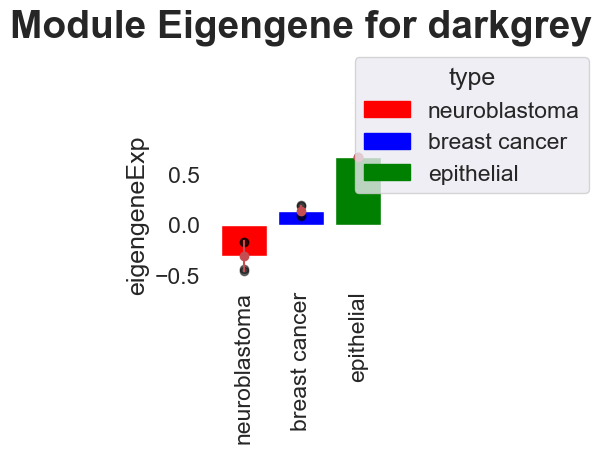

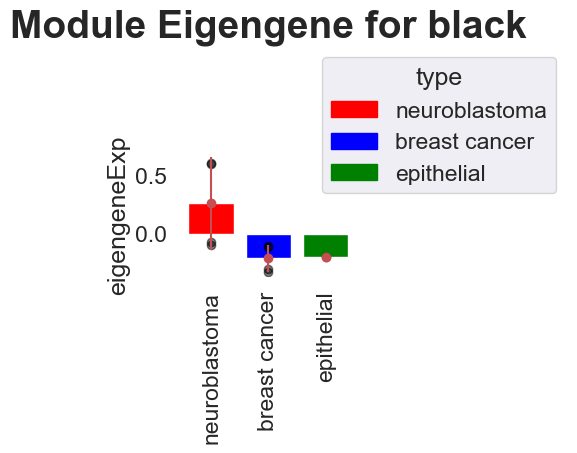

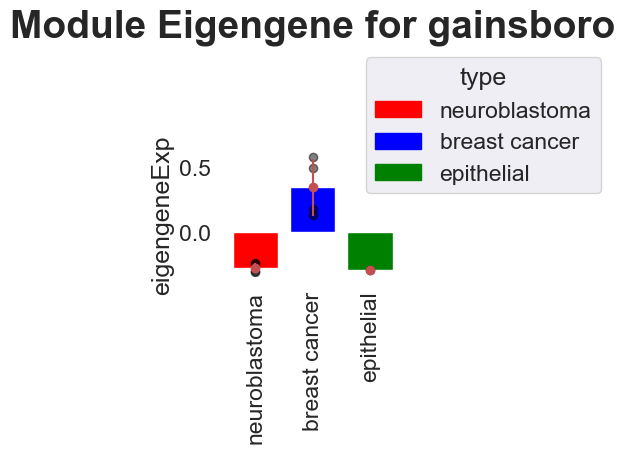

In [48]:
wgcna_object.analyseWGCNA()

In [196]:
wgcna_object.geneExpr.var

,ID,Feature_0
hg38_merged_1-_mirna,NaN,mirna
hg38_merged_10-_mirna,NaN,mirna
hg38_merged_100-_mirna,NaN,mirna
hg38_merged_101-_mirna,NaN,mirna
hg38_merged_102-_mirna,NaN,mirna
...,...,...
hg38_merged_66-_snrna,NaN,snrna
hg38_merged_67-_snrna,NaN,snrna
hg38_merged_68-_snrna,NaN,snrna
hg38_merged_7-_snrna,NaN,snrna


In [49]:
wgcna_object.top_n_hub_genes(moduleName="black", n = 597)

calculating adjacency matrix ...
	Done..



,connectivity,Feature_0,Feature_1,dynamicColors,moduleColors,moduleLabels
hg38_merged_50-_snrna-_,104.641894,snrna,,black,black,0
hg38_merged_385-_mirna-_,103.487968,mirna,,black,black,0
hg38_merged_472-_mirna-_,103.410218,mirna,,black,black,0
hg38_merged_230-_mirna-_5_3p,103.160917,mirna,5_3p,black,black,0
hg38_merged_692-_mirna-_D_box,103.028248,mirna,D_box,black,black,0
...,...,...,...,...,...,...
hg38_merged_480-_mirna-_,1.054153,mirna,,black,black,0
hg38_merged_114-_snorna-_D_box,1.053421,snorna,D_box,black,black,0
hg38_merged_380-_snorna-_5_5p,1.031622,snorna,5_5p,black,black,0
hg38_merged_332-_rrna-_D_box,1.031168,rrna,D_box,black,black,0


In [51]:
import matplotlib.pyplot as plt

colors = ["black", "dimgrey", "whitesmoke", "darkgrey", "gainsboro", "lightgrey"]
number = [597, 264, 89, 152, 132, 241]

final_list = {"color":[], "mirna":[0,0,0,0,0,0], "snorna":[0,0,0,0,0,0], "snrna":[0,0,0,0,0,0], "rrna":[0,0,0,0,0,0]}

i = 0

for k in colors:
    wgcna_object.top_n_hub_genes(moduleName=k, n = number[i]).to_csv(k + ".csv")



calculating adjacency matrix ...
	Done..

calculating adjacency matrix ...
	Done..

calculating adjacency matrix ...
	Done..

calculating adjacency matrix ...
	Done..

calculating adjacency matrix ...
	Done..

calculating adjacency matrix ...
	Done..



In [ ]:
# Annotate based on the presence of a motif